# Probability of Perfect Fairness

plotting only - calculations are in `metricCalculation.ipynb` file

probability of achieving perfect fairness (in different metrics), according to different metrics, for given group/imbalance ratio

- as function of group ratio
- as function of imbalance ratio

In [77]:
import os
import warnings
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

warnings.filterwarnings('ignore')

In [78]:
sample_size = 56
calculations_dir = path.join('out', 'calculations', f'n{sample_size}')
plots_dir = path.join('out', 'plots', f'n{sample_size}')
os.makedirs(plots_dir, exist_ok=True)

df_ir = pd.read_csv(path.join(calculations_dir, 'sonya_xxxxir.csv'))
df_gr = pd.read_csv(path.join(calculations_dir, 'sonya_xxxxgr.csv'))

dfs = {'ir': df_ir, 'gr': df_gr}

color_mapping = {
    'Accuracy equality difference': 'red',
    'Equal opportunity difference': 'green',
    'Predictive equality difference': 'blue',
    'Negative predictive parity difference': 'orange',
    'Positive predictive parity difference': 'purple',
    'Statistical parity': 'black'
}

In [1]:
def melt_df(df, base_metric):
    temp = df.pop(base_metric)
    length = len(df.columns)
    df = pd.melt(df)
    df[base_metric] = list(temp) * length
    return df

In [104]:
def plot_ppf(df, base_metric):
    fig = ggplot(df, aes(x=base_metric, y='value', color='variable'))
    fig += geom_line()
    fig += scale_color_manual(values=color_mapping)
    fig += theme_minimal()
    fig += theme(figure_size=(8, 6))
    fig += ylab('Probability')
    fig += ggtitle('Proportion of perfect fairness')

    print(fig)
    return fig

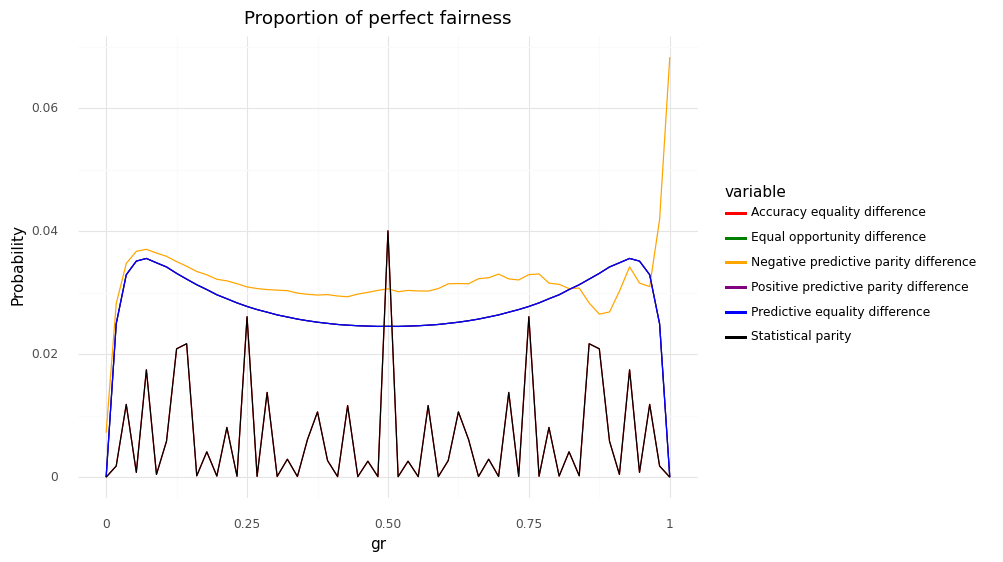

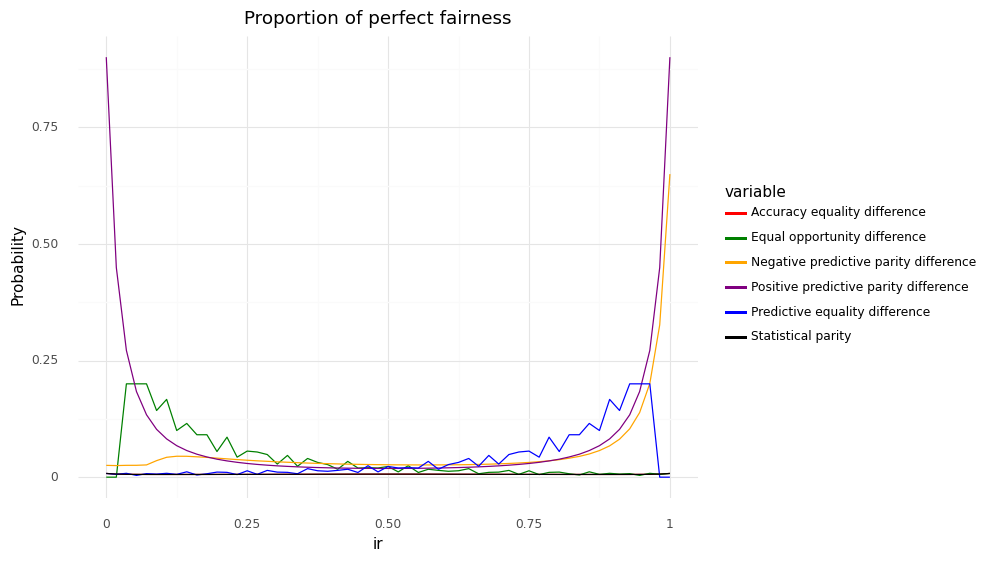

In [14]:
for metric in ['gr', 'ir']:
    fig = plot_ppf(melt_df(dfs[metric].copy(), metric), metric)
    fig.save(path.join(plots_dir, f'ppf_{metric}_1.png'),
             width=8, height=6, dpi=300)

## Matplotlib attempt

In [106]:
def plot_mlp(df, base_metric, color_mapping=color_mapping):
    fig, ax = plt.subplots(figsize=(8, 6))
    for col in df.columns:
        if col == base_metric:
            continue
        ax.plot(df[base_metric], df[col], label=col, color=color_mapping[col])
    ax.set_xlabel(base_metric.upper())
    ax.set_ylabel('Probability')
    ax.set_title('Proportion of perfect fairness')
    ax.legend()
    plt.show()
    return fig

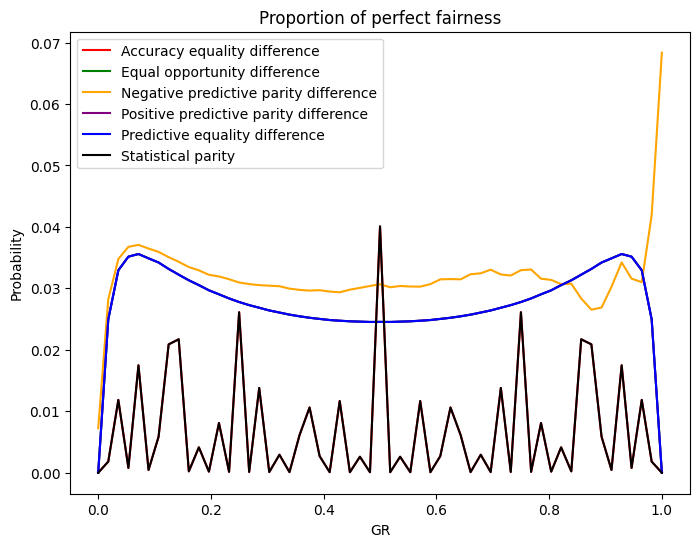

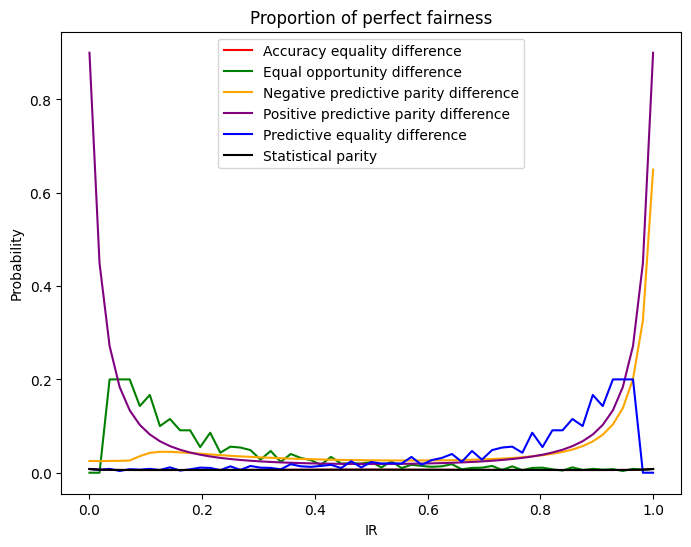

In [89]:
for ratio_type in ['gr', 'ir']:
    fig = plot_mlp(dfs[ratio_type].copy(), ratio_type)      # TODO why copy?
    fig.savefig(path.join(plots_dir, f'ppf_{ratio_type}_2.png'),
                dpi=300)

## Close-up for imbalance ratio

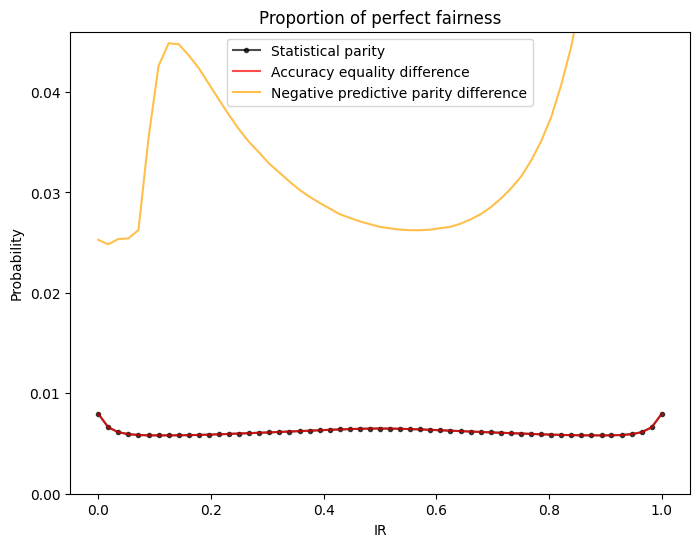

In [81]:
base_metric = 'ir'
df = dfs[base_metric]

fig, ax = plt.subplots(figsize=(8, 6))
for col in ['Statistical parity', 'Accuracy equality difference', 'Negative predictive parity difference']:
    ax.plot(df[base_metric], df[col], label=col,
            alpha=.7, marker='.' if col == 'Statistical parity' else None, color=color_mapping[col])
ax.set_ylim(0, .046)
# ax.set_ylim(0, .01)
ax.set_xlabel(base_metric.upper())
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

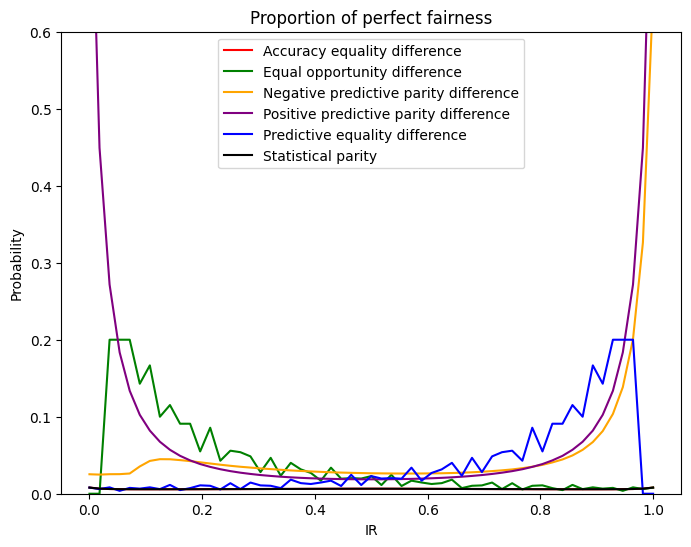

In [83]:
base_metric = 'ir'
df = dfs[base_metric]

fig, ax = plt.subplots(figsize=(8, 6))
for col in df.columns:
    if col == base_metric:
        continue
    ax.plot(df[base_metric], df[col], label=col, color=color_mapping[col])
ax.set_ylim(0, .6)
ax.set_xlabel(base_metric.upper())
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

### smoothing the statistical parity curve (for different GR)
attempt 1 - grouping 2 results together

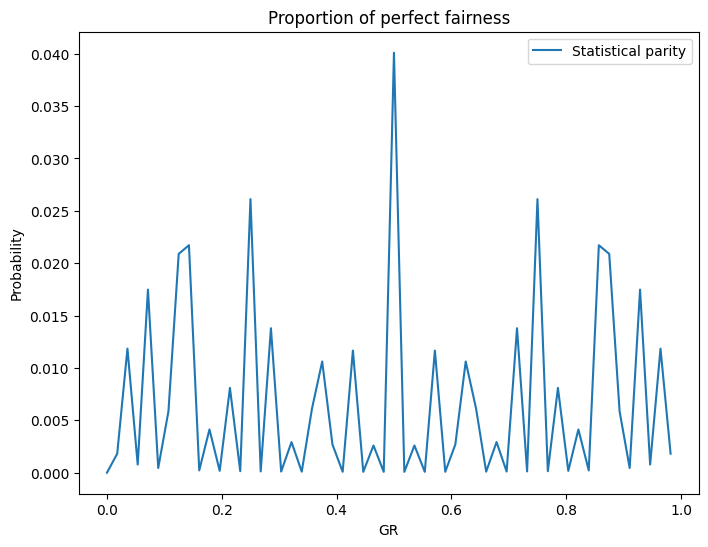

In [21]:
base_metric = 'gr'
x = np.array(dfs[base_metric][base_metric])
y = np.array(dfs[base_metric]['Statistical parity'])

fig, ax = plt.subplots(figsize=(8, 6))
# for col in df.columns:
#     if col == base_metric:
#         continue
#     ax.plot(df[base_metric], df[col], label=col)
ax.plot(x, y, label='Statistical parity')
ax.set_xlabel(base_metric.upper())
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

Smoothed by averaging 2 adjacent results together


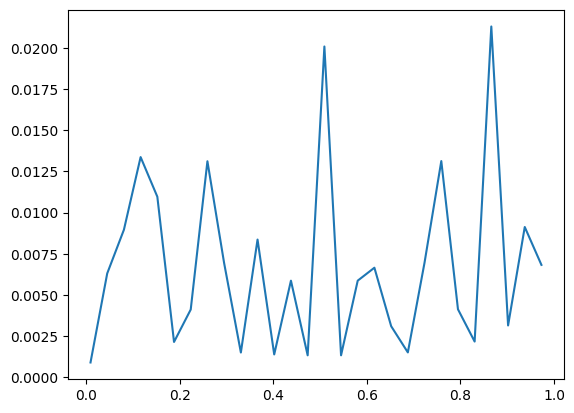

In [35]:
print('Smoothed by averaging 2 adjacent results together')

xx = (x[::2] + x[1::2]) / 2
yy = (y[::2] + y[1::2]) / 2

plt.plot(xx, yy)
plt.show()

Distribution of all and averaged results


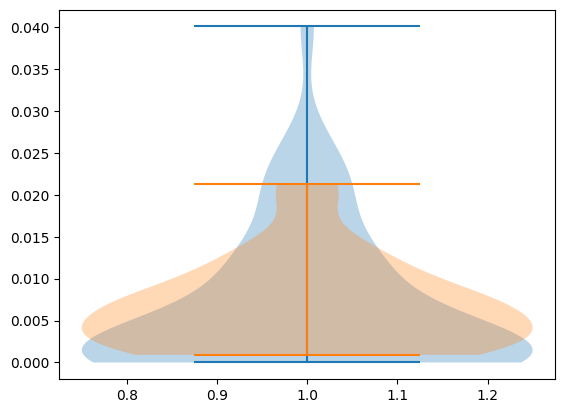

In [36]:
print('Distribution of all and averaged results')

plt.violinplot(y)
plt.violinplot(yy)
plt.show()

Odd and even groups plotted separately


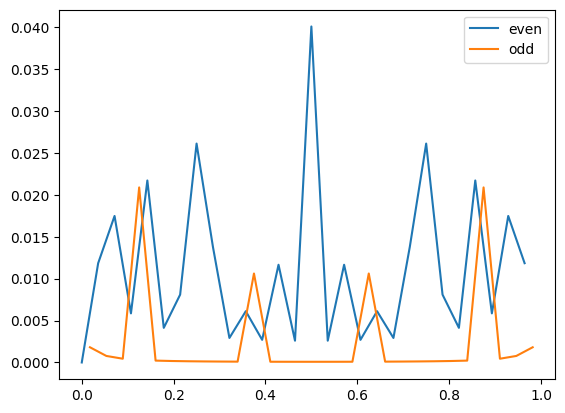

In [34]:
print('Odd and even groups plotted separately')

plt.plot(x[::2], y[::2], label='even')
plt.plot(x[1::2], y[1::2], label='odd')
plt.legend()
plt.show()

Group ratio on separate axes


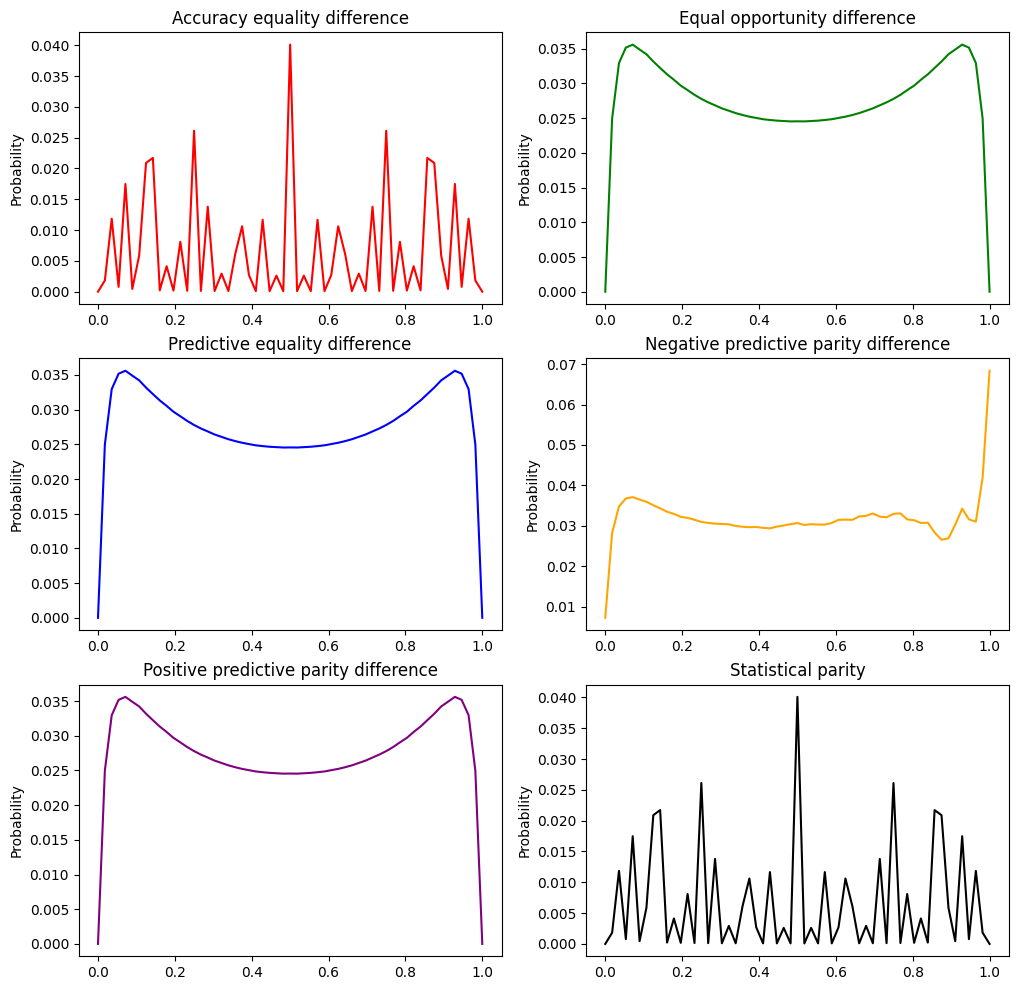

In [92]:
print("Group ratio on separate axes")
base_metric = 'gr'
df = dfs[base_metric]

fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, metric in enumerate(color_mapping.keys()):
    ax[i // 2, i % 2].plot(df[base_metric], df[metric], label=metric, color=color_mapping[metric])
    # ax[i // 2, i % 2].set_xlabel(base_metric.upper())
    ax[i // 2, i % 2].set_ylabel('Probability')
    ax[i // 2, i % 2].set_title(metric)
    # ax[i // 2, i % 2].legend()
plt.show()

## Imperfect perfection - results with epsilon

In [95]:
dfs = {}
epsilon = 1./50.

for ratio in ['gr', 'ir']:
    dfs[ratio] = pd.read_csv(path.join(calculations_dir, f'ppf_{ratio}_eps{epsilon}.csv'))

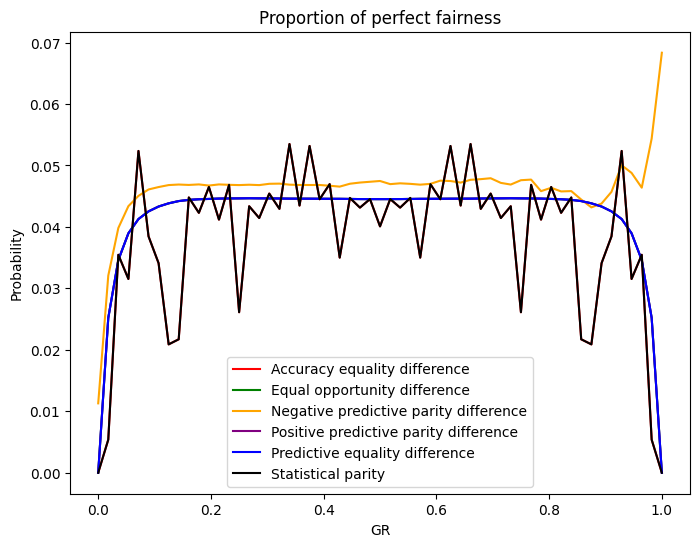

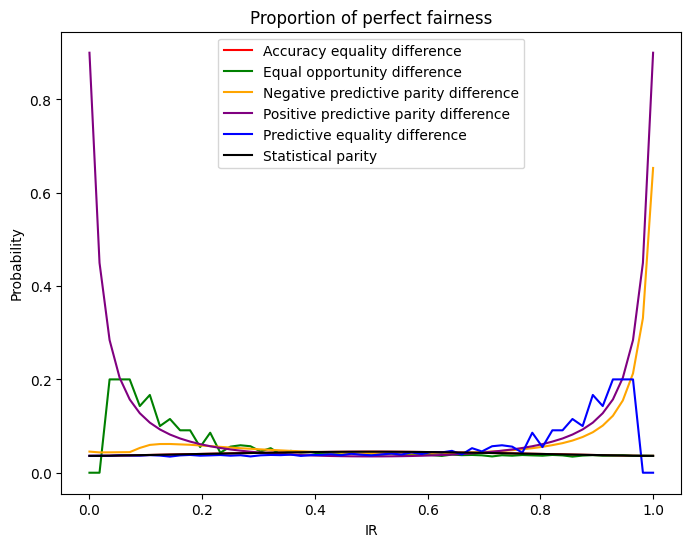

In [96]:
for ratio_type in ['gr', 'ir']:
    fig = plot_mlp(dfs[ratio_type].copy(), ratio_type)      # TODO why copy?
    fig.savefig(path.join(plots_dir, f'ppf_{ratio_type}_e{epsilon}_2.png'),
                dpi=300)

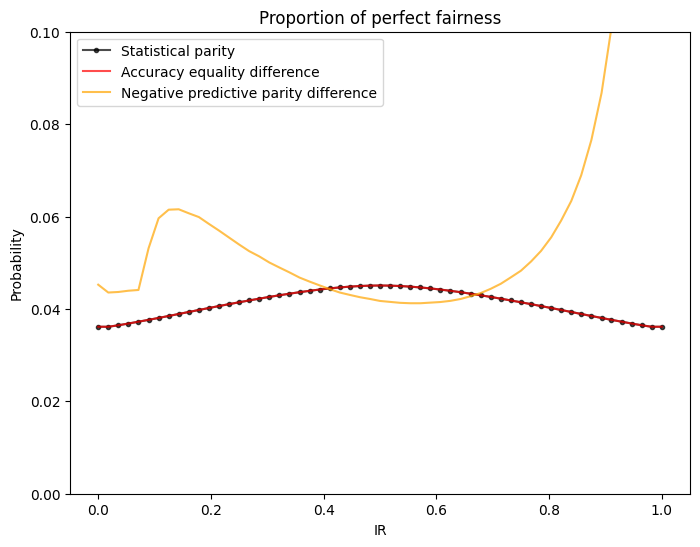

In [99]:
base_metric = 'ir'
df = dfs[base_metric]

fig, ax = plt.subplots(figsize=(8, 6))
for col in ['Statistical parity', 'Accuracy equality difference', 'Negative predictive parity difference']:
    ax.plot(df[base_metric], df[col], label=col,
            alpha=.7, marker='.' if col == 'Statistical parity' else None, color=color_mapping[col])
ax.set_ylim(0, .1)
# ax.set_ylim(0, .01)
ax.set_xlabel(base_metric.upper())
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

# Ratio based metrics

In [102]:
dfs_ratio = {}
epsilon = 1./50.

for ratio in ['gr', 'ir']:
    dfs_ratio[ratio] = pd.read_csv(path.join(calculations_dir, f'ppf_{ratio}_ratios_eps{epsilon}.csv'))

ratio_metrics_colors = {    # { file: metric name }
    'Accuracy equality ratio': 'green',
    'Disparate impact': 'red',
    'Equal opportunity ratio': 'blue',
    '(Positive) predictive parity ratio': 'purple',
    'Predictive equality ratio': 'yellow',
}

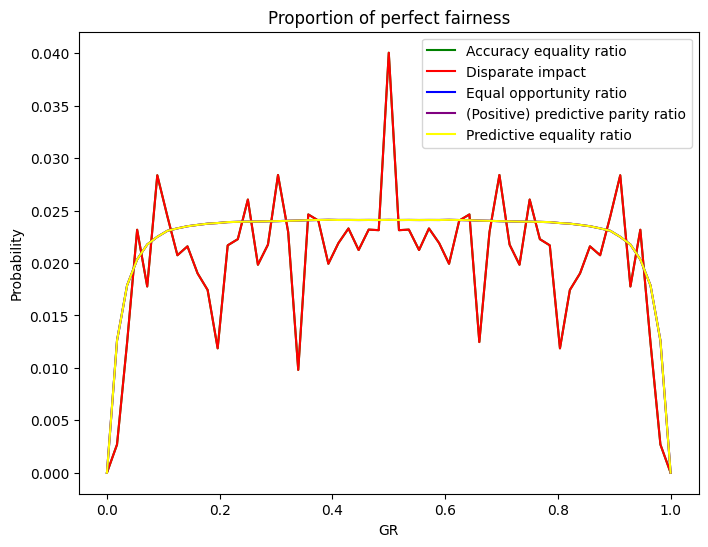

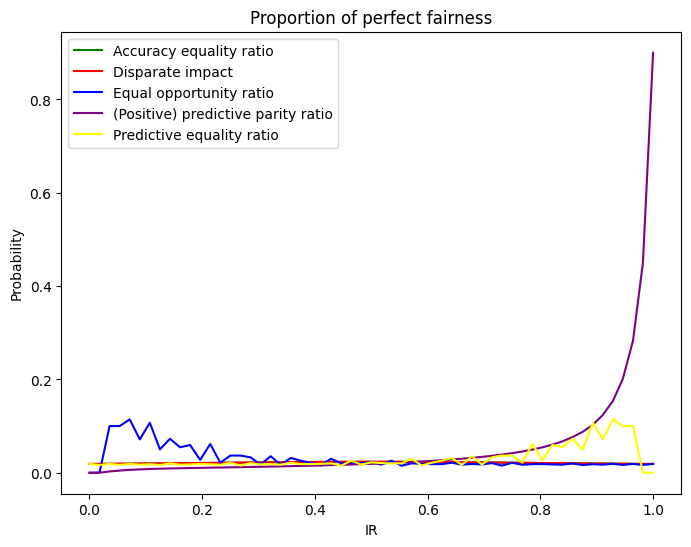

In [108]:
for ratio_type in ['gr', 'ir']:
    fig = plot_mlp(dfs_ratio[ratio_type].copy(), ratio_type, ratio_metrics_colors)      # TODO why copy?
    fig.savefig(path.join(plots_dir, f'ppf_{ratio_type}_ratios_e{epsilon}_2.png'),
                dpi=300)